In [241]:
# The cache directories:
cache_path       = '/data/crcns2021'
image_cache_path = f'{cache_path}/annot-images'
v123_cache_path  = f'{cache_path}/annot-v123'
csulc_cache_path = f'{cache_path}/annot-csulc'
trace_save_path = f'{cache_path}/results/data_branch/save'
labels_path = f'{cache_path}/results/labels'

import os
# If you aren't using /data
os.environ['HCPANNOT_LOAD_PATH'] = cache_path

In [284]:
import os 
import sys
sys.path.append('..')
import numpy as np
import neuropythy as ny
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import logging
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## figure setting
For some reason the only font family I could found was serif.

In [243]:
import pylab as pl
la = pl.matplotlib.font_manager.FontManager()
lu = pl.matplotlib.font_manager.FontProperties(family = 'monospace')
la.findfont(lu)

'/home/jiyeongha/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf'

In [299]:
import matplotlib as mpl
# Additional matplotlib preferences:
font_data = {'size': 10,
             'weight': 'light',
            'family': 'monospace'} # missing fonts 
mpl.rc('font', **font_data) 
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72 * 2
mpl.rcParams['savefig.dpi'] = 72 * 4

In [245]:
# Now we can import the hcp-annot-vc library.
import hcpannot
hcpannot.interface.default_load_path = cache_path  
from hcpannot import (vc_plan, 
                      save_contours, 
                      load_contours,
                      subject_ids)

In [246]:
rater_list = ['BrendaQiu',
              'bogengsong',
              'JiyeongHa',
              'lindazelinzhao',
              'nourahboujaber',
              'jennifertepan']

## Helper functions for plotting mean contours across subjects

In [296]:
def get_native_surface(subject, hemi):
    surf = ny.data['hcp_lines'].subjects[subject].hemis[hemi]
    return surf

def roi_trace_to_path(dat, native_surface, roi, hemi):
    # grab a trace
    trace = dat['traces'][roi]
    # get the subject's hemisphere mesh
    path = trace.to_path(native_surface)
    return path
    
def get_path_coords_in_fsaverage(path, native_surface):
    fmap = ny.to_flatmap('occipital_pole', native_surface)
    fsa_coords = fmap.unaddress(path.addresses)
    return fsa_coords

def normalize_coords(fsa_coords, n_points=800):
    curve = ny.util.CurveSpline(fsa_coords)
    normed_fsa_coords = curve.linspace(n_points)
    return normed_fsa_coords

def arrange_multiple_coords_into_dict(normed_x_list, 
                                      normed_y_list, 
                                      normed_fsa_coords_keys=None, 
                                      average=True):
    if normed_fsa_coords_keys is None:
        normed_fsa_coords_keys = np.range(0, len(normed_fsa_coords_list))
    normed_fsa_coords_vals = [np.asarray((x,y)) for x, y in zip(normed_x_list, normed_y_list)]  
    normed_fsa_coords_dict = dict(zip(normed_fsa_coords_keys, normed_fsa_coords_vals))
    if average is True:
        avg_x = np.mean(normed_x_list, axis=0)
        avg_y = np.mean(normed_y_list, axis=0)
        normed_fsa_coords_dict['avg'] = np.asarray((avg_x,avg_y))
    return normed_fsa_coords_dict

def _display_msg(message, verbose):
    if verbose:
        print(message)
    else:
        pass

def plot_mean_contours_across_subjects(rater, 
                                       roi, 
                                       subject_list, 
                                       hemi, 
                                       n_points=800,
                                       verbose=False,
                                       average=True,
                                       trace_save_path=None):
    x_list, y_list = [],[]
    _display_msg(f'**number of subjects: {len(subject_list)}\n**nuber of points:{n_points}', verbose)
        
    for sid in tqdm(subject_list):
        total_start = time.time()
        _display_msg(f'---------------------', verbose)
        _display_msg(f'subject no.{sid}', verbose)
        annot = vc_plan(rater=rater, sid=sid, hemisphere=hemi, save_path=trace_save_path)
        _display_msg(f'loading surface mesh....', verbose)
        start = time.time()
        native_surf = get_native_surface(sid, hemi)
        end = time.time()
        _display_msg(f'done! elpased time is {np.round(end-start,3)} sec.\nNow converting trace to path...', verbose)
        start = time.time()
        path = roi_trace_to_path(annot, native_surf, roi, hemi)
        end = time.time()
        _display_msg(f'done! elpased time is {np.round(end-start,3)} sec', verbose)
        _display_msg('Now transforming the path to fsaverage space...', verbose)
        start = time.time()
        fsa_coords = get_path_coords_in_fsaverage(path, native_surf)
        end = time.time()
        _display_msg(f'done! elpased time is {np.round(end-start,3)} sec.\nnow interpolating the coordinates..', verbose)
        (x,y) = normalize_coords(fsa_coords, n_points)
        x_list.append(x)
        y_list.append(y)
        total_end = time.time()
        _display_msg(f'subject no. {sid} is finished! Total time: {np.round(total_end - total_start,2)} sec', verbose)
    normed_fsa_coords_dict = arrange_multiple_coords_into_dict(x_list, y_list, subject_list, average)
    return normed_fsa_coords_dict


## Plot functions

In [281]:
def plot_multiple_traces(normed_fsa_coords_dict, legend=True, average_only=False, **kwargs):
    title = kwargs.pop('title', None)
    if average_only:
        normed_fsa_coords_dict = {'avg': normed_fsa_coords_dict['avg']}
    n_lines = len(normed_fsa_coords_dict.keys())
    fig, ax = plt.subplots(1,1)
    pal = plt.cm.gist_rainbow(np.linspace(0, 1, n_lines))
    color = iter(pal)
    for k, fsa_coords in normed_fsa_coords_dict.items():
        (x,y) = fsa_coords
        c=next(color)
        if k == 'avg':
            c = 'k'
        ax.plot(x,y, label=str(k), color=c, **kwargs)
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncols=2)
    ax.get_legend().set_visible(legend)
    plt.tight_layout()

## Test

had to fork neuropythy & git clone the fork and pip install -e . and then edit all np.object to object.
Downgrading numpy==1.25.5 or the version listed on the neuropythy document was not successful due to another error on the top importing ipython-related packages

In [8]:
# First: Average across two raters for the same subject.

# Get the traces for one rater and one subject.
dat1 = vc_plan(
    rater=rater1,
    sid=sid1,
    hemisphere='lh',
    save_path=trace_save_path)
dat2 = vc_plan(
    rater=rater1,
    sid=sid2,
    hemisphere='lh',
    save_path=trace_save_path)

path1 = roi_trace_to_path(dat1, subject=sid1, roi='hV4', hemi='lh')

In [297]:
normed_fsa_coords_dict = plot_mean_contours_across_subjects(rater=rater_list[0], 
                                                            roi='hV4', 
                                                            subject_list=subject_ids[:10], 
                                                            hemi='lh', 
                                                            n_points=600, 
                                                            verbose=True,
                                                            trace_save_path=trace_save_path)

**number of subjects: 10
**nuber of points:600


  0%|          | 0/10 [00:00<?, ?it/s]

---------------------
subject no.100610
loading surface mesh....
done! elpased time is 0.0 sec.
Now converting trace to path...
done! elpased time is 4.772 sec
Now transforming the path to fsaverage space...
done! elpased time is 1.594 sec.
now interpolating the coordinates..
subject no. 100610 is finished! Total time: 6.37 sec
---------------------
subject no.102311
loading surface mesh....
done! elpased time is 0.0 sec.
Now converting trace to path...
done! elpased time is 4.336 sec
Now transforming the path to fsaverage space...
done! elpased time is 1.408 sec.
now interpolating the coordinates..
subject no. 102311 is finished! Total time: 5.75 sec
---------------------
subject no.102816
loading surface mesh....
done! elpased time is 0.0 sec.
Now converting trace to path...
done! elpased time is 4.423 sec
Now transforming the path to fsaverage space...
done! elpased time is 1.366 sec.
now interpolating the coordinates..
subject no. 102816 is finished! Total time: 5.79 sec
----------

## Plot

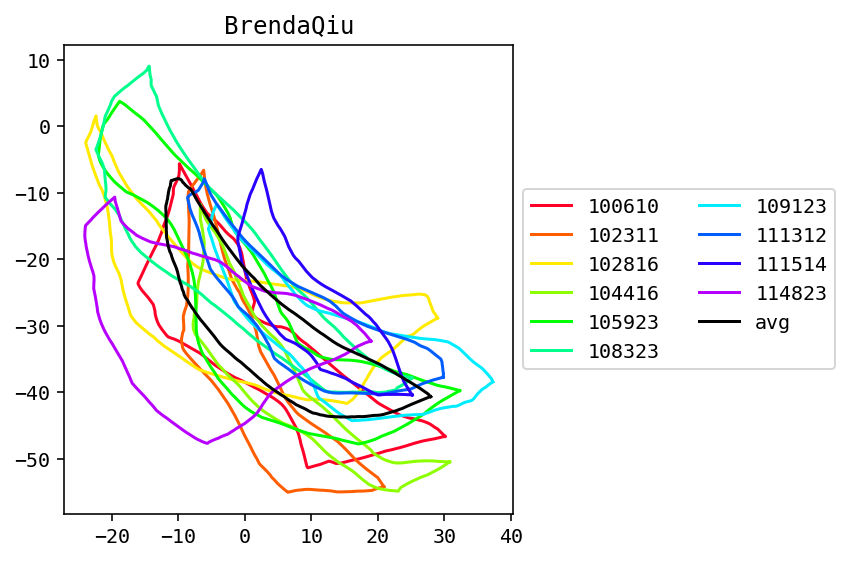

In [300]:
plot_multiple_traces(normed_fsa_coords_dict, 
                     average_only=False, 
                     title=rater_list[0])

In [ ]:
for rater in rater_list:
    normed_fsa_coords_dict = plot_mean_contours_across_subjects(rater=rater, 
                                                                roi='hV4', 
                                                                subject_list=subject_ids[:30], 
                                                                hemi='lh', 
                                                                n_points=600, 
                                                                verbose=True,
                                                                trace_save_path=trace_save_path)
    plot_multiple_traces(normed_fsa_coords_dict, 
                     average_only=False, 
                     title=rater)

**number of subjects: 30
**nuber of points:600


  0%|          | 0/30 [00:00<?, ?it/s]

---------------------
subject no.100610
loading surface mesh....
done! elpased time is 0.0 sec.
Now converting trace to path...


## for savings..

In [ ]:
ny.save(f'{sid1}_{rater1}_fsacoords.mgz', fsa_normalized_coords1)
